# Εργαστηριακή Άσκηση 3
### Προσαρμοσμένα φίλτρα και L-ASK
Αφού μελετήσετε το Κεφάλαιο 3 και, ειδικότερα, το Παράδειγμα 3.2 των
σημειώσεων, να αντιγράψετε τον Κώδικα 3.3 αυτού του παραδείγματος σε αρχείο με
το όνομα ask_errors.m (ο κώδικας επαναλαμβάνεται εδώ για διευκόλυνση). Να
εκτελέσετε στη συνέχεια τα ακόλουθα:


## Μέρος 1: Εισαγωγή
Διερεύνηση του κώδικα εξομοίωσης
(α) Να τροποποιηθεί ο κώδικας, ώστε τα L στοιχεία του διανύσματος x στην εντολή
14 να λαμβάνουν τιμές από το σύνολο {±d/2, ±3d/2, ±5d/2... }, όπου η απόσταση
d των σημείων θα δίνεται ως παράμετρος. Χρησιμοποιώντας για τη συνέχεια την
τιμή d=5, να επαληθεύσετε, με υπολογισμό και προβολή σχετικού ιστογράμματος,
ότι τα στοιχεία του διανύσματος x ακολουθούν πράγματι την ομοιόμορφη
κατανομή. Χρησιμοποιήστε k=mod(nnnnn,2)+3, όπου nnnnn το τελευταίο 5-
ψήφιο τμήμα του αριθμού μητρώου σας.

Υπόδειξη: Να παραχθούν (με την εντολή 14) τουλάχιστον 40.000 τυχαίοι ακέραιοι, και να
χρησιμοποιηθεί η εντολή hist(x,A) για τον υπολογισμό και την προβολή του ιστογράμματος,όπου Α το διάνυσμα των L διαφορετικών τιμών αυτών των ακεραίων. Να τροποποιηθεί
κατάλληλα η εντολή 15 για τον θεωρητικό υπολογισμό της ισχύος και να γίνει
επαλήθευση με την εντολή 16. Ομοίως, να τροποποιηθεί κατάλληλα και η εντολή 23.
(β) Με τιμές των παραμέτρων της συνάρτησης k=4, M=60000, nsamp=20 και
EbNo=12 να εκτελέσετε τις εντολές 11 έως 22 και, στη συνέχεια, να σχεδιάσετε το
ιστόγραμμα του z με την εντολή hist(z,200). Να επαναλάβετε το παραπάνω για
EbNo=16 και EbNo=20. Τι παρατηρείτε; Να εξηγήσετε τις διαφορές στα τρία
διαγράμματα.

In [1]:
from scipy import signal
# Ανατρέξτε στην τεκμηρίωση της βιβλιοθήκης scipy.signal
# https://docs.scipy.org/doc/scipy/reference/signal.html
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def ask_errors(k,M,nsamp,EbN0_db):
    
    L = 2**k
    SNR_db = EbN0_db - 10*np.log10(nsamp/2/k)
    SNR = 10 ** (SNR_db * 0.1)
    x = 2*np.floor(L*np.random.rand(M)) - L + 1
    P_x = (L*L-1) / 3
    Measured_x = np.sum(x*x)/len(x)

    y = []
    for i in range(len(x)):
        for j in range(nsamp):
            y.append(x[i])
    y = np.array(y)

    noise = np.random.normal(0, np.sqrt(Measured_x/SNR),len(y))
    y_noisy = y + noise

    y = np.reshape(y_noisy, (M, nsamp))
    matched = np.ones((nsamp,1))
    z = np.matmul(y, matched)
    z = z / nsamp
    l = np.arange(-L+1,L,2)

    z = z[:,0]
    for i in range(len(z)):
        differences = np.abs(l-z[i]) # Πίνακας με τις διαφορές του σήματος από τα επίπεδα
        m = min(differences)
        [index], = np.where(differences == m)
        z[i] = l[index]
    
    errors = 0
    for i in range(len(z)):
        if x[i] != z[i]:
            errors += 1
    
    return errors

errors = ask_errors(4,50000,16,12)
print(errors)

errors = ask_errors(4,50000,16,14)
print(errors)

errors = ask_errors(4,50000,16,18)
print(errors)

10469


5853


648


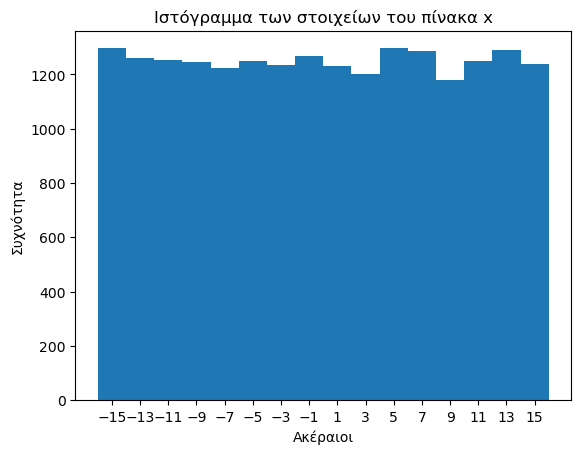

In [3]:
k = 4
M = 20000
L = 2**k

x = 2*np.floor(L*np.random.rand(M)) - L + 1
# Ο πίνακας bins περιέχει τα όρια των στηλών του ιστογράμματος ([-L -L+2 ... L-2 L])
bins = np.arange(-L,L+2,2)
# Ο πίνακας Α περιέχει τα μέσα των στηλών του ιστογράμματος ([-L+1 -L+3 ... L-3 L-1])
A = np.arange(-(L-1),L,2)
fig, ax = plt.subplots(1,1)
# Δημιουργούμε το ιστόγραμμα δίνοντας τα όρια των στηλών 
plt.hist(x,bins)
# Αλλάζουμε τον άξονα x, ώστε να εμφανίζει το μέσο κάθε bin
ax.set_xticks(A)
plt.xlabel("Ακέραιοι")
plt.ylabel("Συχνότητα")
plt.title("Ιστόγραμμα των στοιχείων του πίνακα x")
plt.show()

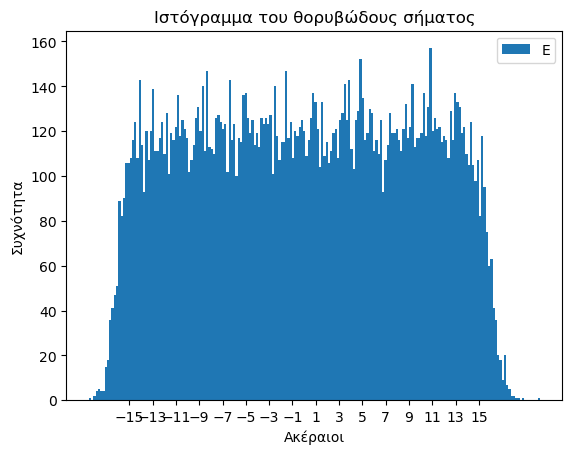

In [4]:
k = 4
M = 20000
nsamp = 16
EbN0_db = 10

L = 2**k
SNR_db = EbN0_db - 10*np.log10(nsamp/2/k)
SNR = 10 ** (SNR_db * 0.1)
x = 2*np.floor(L*np.random.rand(M)) - L + 1
P_x = (L*L-1) / 3
Measured_x = np.sum(x*x)/len(x)

y = []
for i in range(len(x)):
    for j in range(nsamp):
        y.append(x[i])
y = np.array(y)

noise = np.random.normal(0, np.sqrt(Measured_x/SNR),len(y))
y_noisy = y + noise

y = np.reshape(y_noisy, (M, nsamp))
matched = np.ones((nsamp,1))
z = np.matmul(y, matched)
z = z / nsamp
    
fig, ax = plt.subplots(1,1)
plt.hist(z,200)
ax.set_xticks(A)
plt.xlabel("Ακέραιοι")
plt.ylabel("Συχνότητα")
plt.legend("Eb/N0 = 10")
plt.title('Ιστόγραμμα του θορυβώδους σήματος')

plt.show()

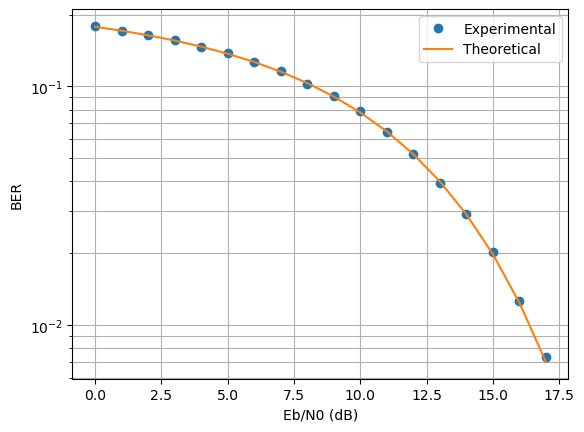

In [5]:
from scipy.special import erfc

M = 20000
k = 4
L = 2**k
nsamp = 16

ber = np.zeros(18)
for index in range (0,18):
    ber[index] = ask_errors(k,M,nsamp,index)/M/np.log2(L)

plt.semilogy(ber,'o')
plt.grid(True,which='both')
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")

EbN0_db = np.arange(0,18,1)
EbN0 = 10**(EbN0_db/10)
ber_theoretical = (((L-1)/L)*erfc(np.sqrt(EbN0*(3*np.log2(L))/(L**2-1))))/k
plt.semilogy(ber_theoretical)

plt.legend(['Experimental','Theoretical'])

plt.show()